<a href="https://colab.research.google.com/github/khoadangtruong/Customer-Segmentation/blob/master/Customer_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = '/content/drive/MyDrive/data/Online Retail.csv'
data = pd.read_csv(data_path)

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.shape

(541909, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
data['CustomerID'] = data['CustomerID'].astype('object')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [12]:
data['Month'] = data['InvoiceDate'].dt.month
data['Hour'] = data['InvoiceDate'].dt.hour

In [21]:
data['Revenue'] = data['Quantity'] * data['UnitPrice']

In [22]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Hour,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,20.34


In [23]:
obj_col_list = list(data.select_dtypes('object').columns)
obj_col_list

['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

In [24]:
for col in obj_col_list:
    print(f"{col}: {data[col].nunique()}")

InvoiceNo: 25900
StockCode: 4070
Description: 4223
CustomerID: 4372
Country: 38


In [25]:
sns.set_theme()

In [37]:
country_revenue_df = pd.DataFrame(data.groupby('Country')['Revenue'].sum())
country_revenue_df.sort_values('Revenue', inplace = True, ascending = False)
country_revenue_df

,Revenue
Country,
United Kingdom,8187806.364
Netherlands,284661.540
EIRE,263276.820
Germany,221698.210
France,197403.900
Australia,137077.270
Switzerland,56385.350
Spain,54774.580
Belgium,40910.960


In [39]:
top_10_country = country_revenue_df.head(10)

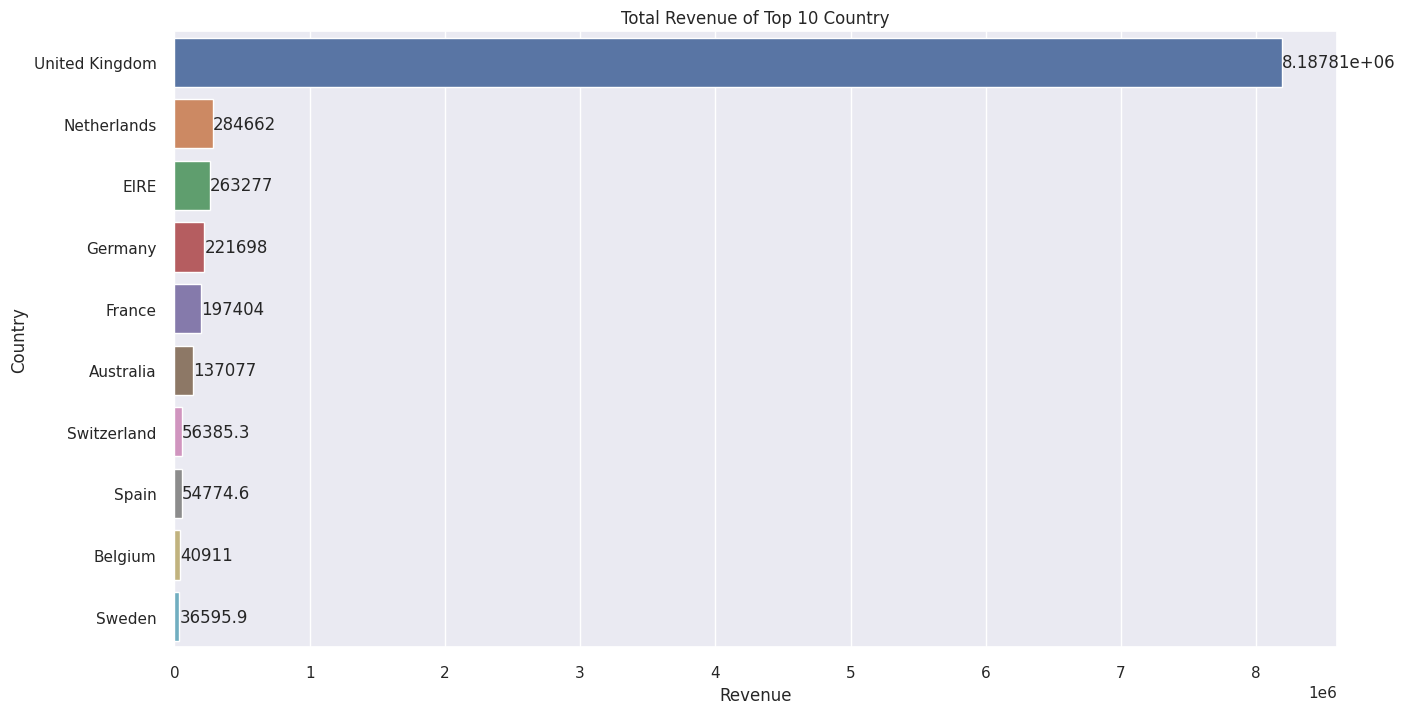

In [36]:
fig, ax = plt.subplots(figsize = (15, 8))

ax = sns.barplot(data = top_10_country, x = 'Revenue', y = top_10_country.index)
plt.title('Total Revenue of Top 10 Country')
ax.bar_label(ax.containers[0])

plt.show()

In [ ]:
country_qty_sold_df = pd.DataFrame(data.groupby('Country')['Quantity'].sum())
country_qty_sold_df.sort_values('Quantity', inplace = True, ascending = False)
country_qty_sold_df

In [41]:
top_10_country_qty_sold_df = country_qty_sold_df.head(10)
top_10_country_qty_sold_df

,Quantity
Country,
United Kingdom,4263829
Netherlands,200128
EIRE,142637
Germany,117448
France,110480
Australia,83653
Sweden,35637
Switzerland,30325
Spain,26824


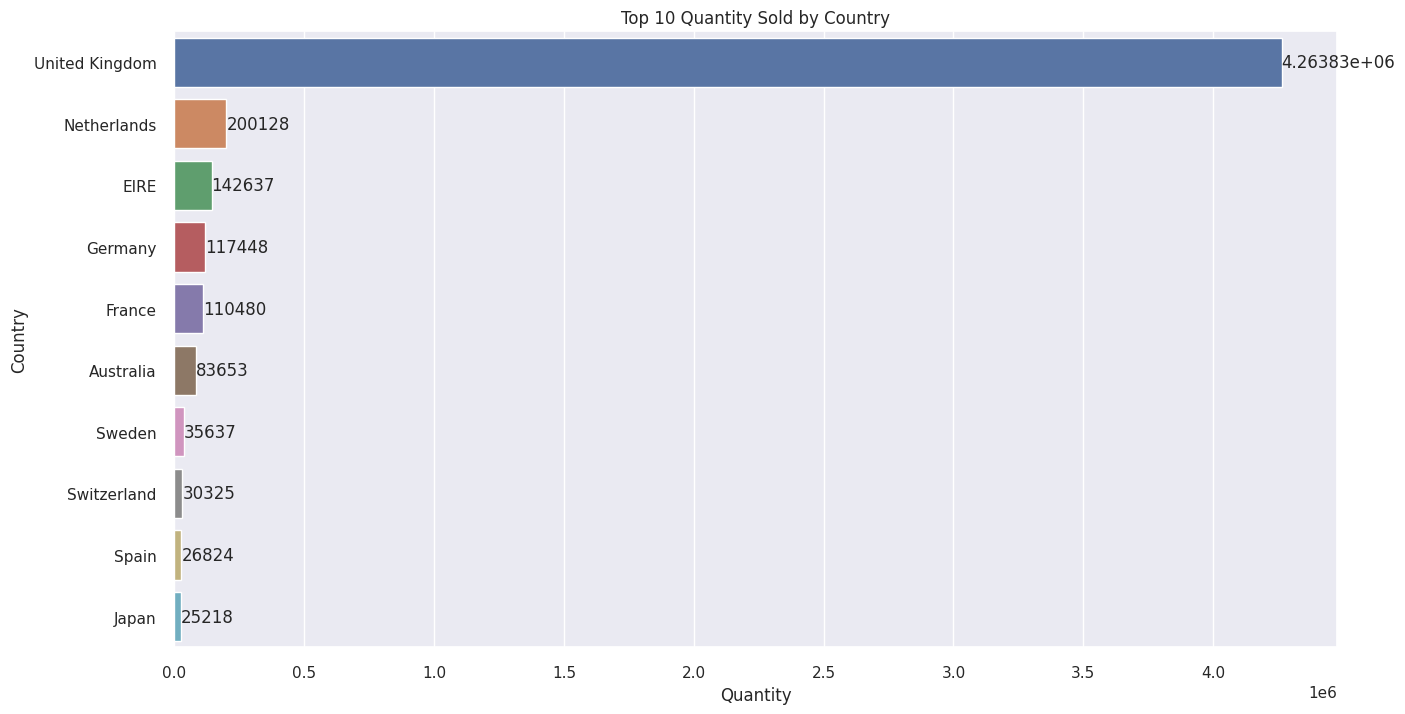

In [42]:
fig, ax = plt.subplots(figsize = (15, 8))

ax = sns.barplot(data = top_10_country_qty_sold_df, x = 'Quantity', y = top_10_country_qty_sold_df.index)
plt.title('Top 10 Quantity Sold by Country')
ax.bar_label(ax.containers[0])

plt.show()

In [44]:
uk_df = data[data['Country'] == 'United Kingdom']
uk_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Hour,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,8,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,12,12,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,12,12,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,12,12,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,12,12,214.80


In [45]:
uk_month_revenue_df = pd.DataFrame(uk_df.groupby('Month')['Revenue'].sum())
uk_month_revenue_df

,Revenue
Month,
1,434308.300
2,408247.910
3,559707.390
4,442254.041
5,596459.860
6,554478.350
7,565479.841
8,539130.500
9,862018.152


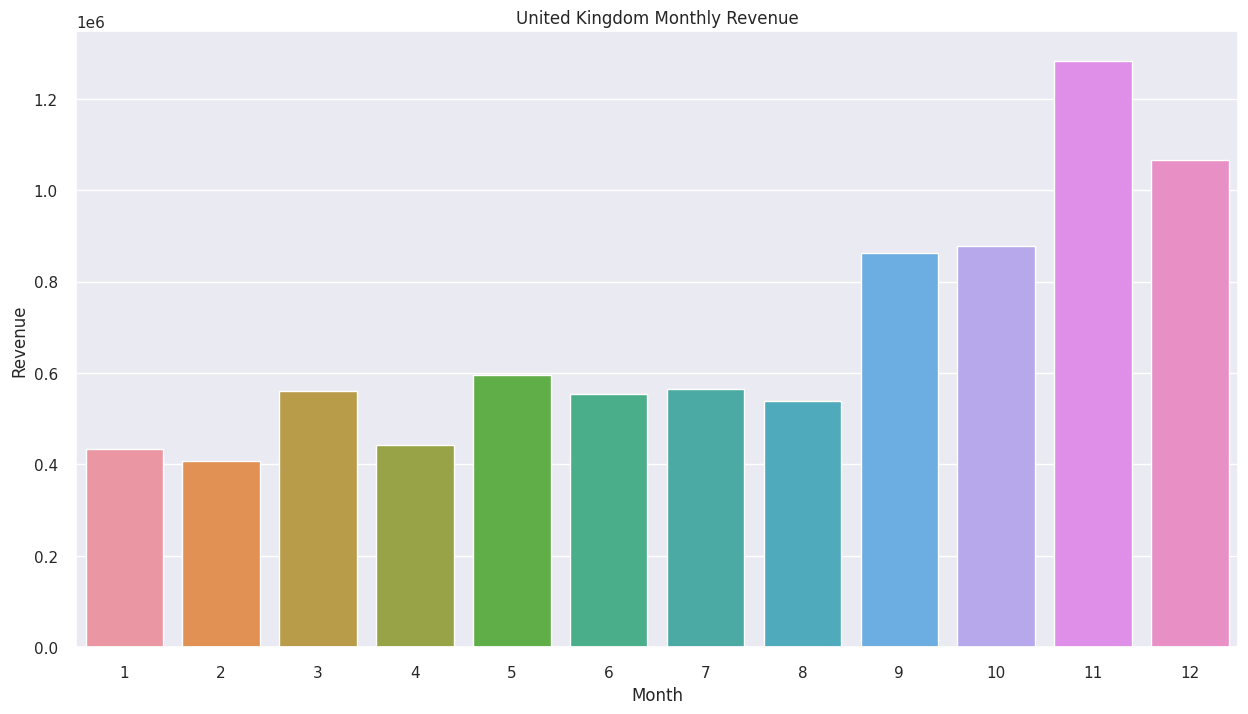

In [46]:
fig, ax = plt.subplots(figsize = (15, 8))

ax = sns.barplot(
    data = uk_month_revenue_df, 
    y = 'Revenue', x = uk_month_revenue_df.index
)
plt.title('United Kingdom Monthly Revenue')

plt.show()

In [47]:
uk_hour_revenue_df = pd.DataFrame(uk_df.groupby('Hour')['Revenue'].sum())
uk_hour_revenue_df

,Revenue
Hour,
6,-204.780
7,11074.690
8,185242.500
9,605771.321
10,1067120.071
11,955581.030
12,1141464.400
13,985829.460
14,918467.961


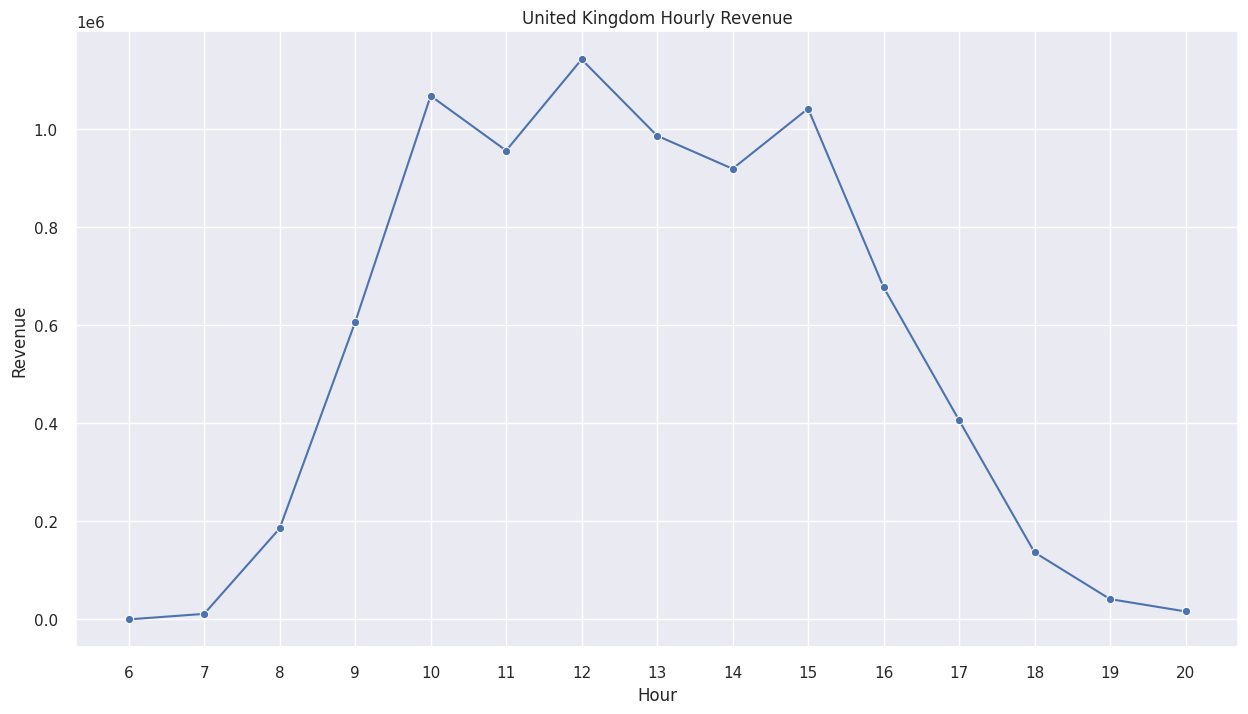

In [57]:
fig, ax = plt.subplots(figsize = (15, 8))

sns.lineplot(
    data = uk_hour_revenue_df, 
    x = uk_hour_revenue_df.index, 
    y = 'Revenue', 
    marker = "o", dashes = False
)
plt.title('United Kingdom Hourly Revenue')
plt.xticks(uk_hour_revenue_df.index)

plt.show()

In [58]:
product_revenue = pd.DataFrame(uk_df.groupby('Description')['Revenue'].sum())
product_revenue.sort_values('Revenue', inplace = True, ascending = False)

In [60]:
top_10_product = product_revenue.head(10)
top_10_product

,Revenue
Description,
DOTCOM POSTAGE,206245.48
REGENCY CAKESTAND 3 TIER,134405.94
WHITE HANGING HEART T-LIGHT HOLDER,93953.07
PARTY BUNTING,92501.73
JUMBO BAG RED RETROSPOT,84516.44
PAPER CHAIN KIT 50'S CHRISTMAS,61888.19
ASSORTED COLOUR BIRD ORNAMENT,54662.15
CHILLI LIGHTS,52986.86
PICNIC BASKET WICKER 60 PIECES,39619.50


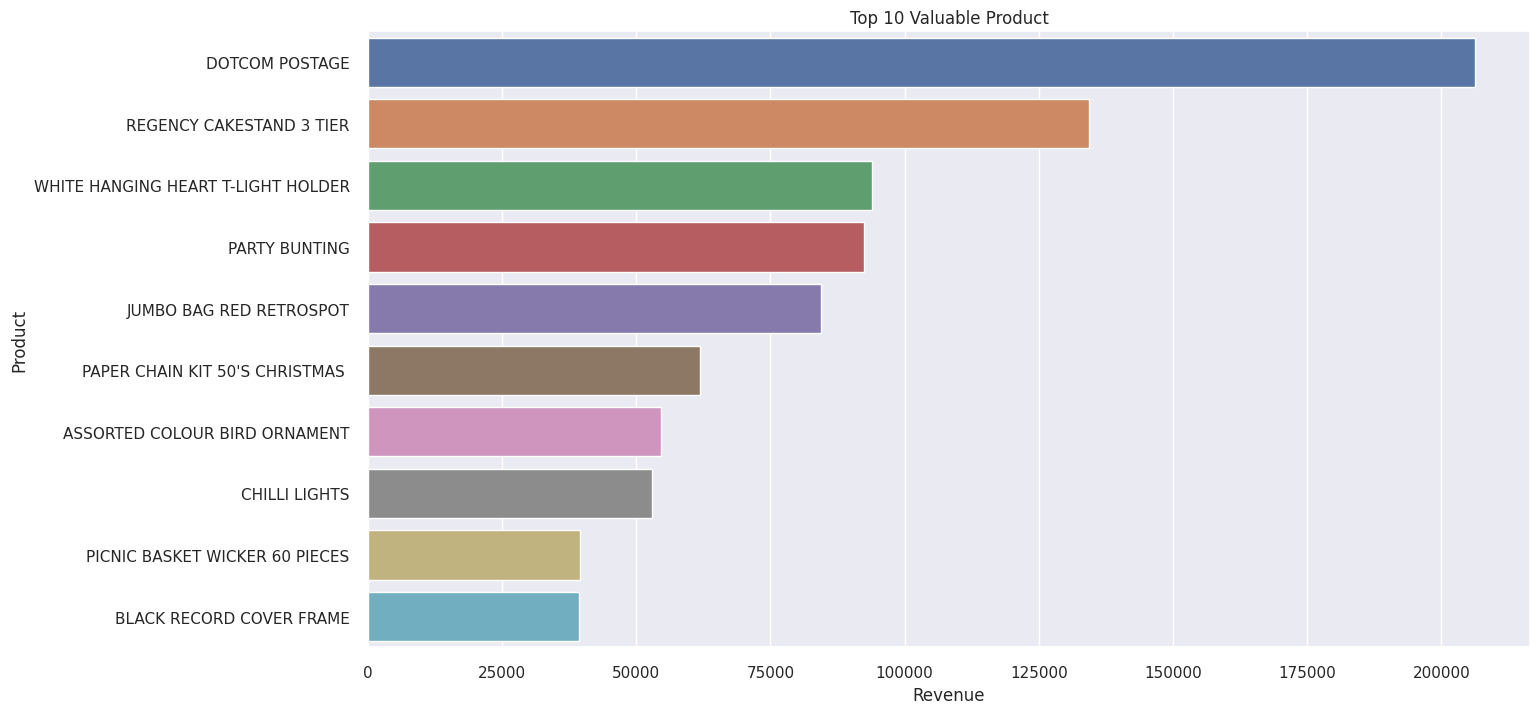

In [67]:
fig = plt.figure(figsize = (15, 8))

sns.barplot(
    data = top_10_product, 
    y = top_10_product.index, x = 'Revenue'
)
plt.title('Top 10 Valuable Product')
plt.ylabel('Product')

plt.show()

In [63]:
product_sold = pd.DataFrame(uk_df.groupby('Description')['Quantity'].sum())
product_sold.sort_values('Quantity', inplace = True, ascending = False)

In [64]:
top_10_product_sold = product_sold.head(10)
top_10_product_sold

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,48326
JUMBO BAG RED RETROSPOT,43167
POPCORN HOLDER,34365
ASSORTED COLOUR BIRD ORNAMENT,33679
WHITE HANGING HEART T-LIGHT HOLDER,33193
PACK OF 12 LONDON TISSUES,25307
PACK OF 72 RETROSPOT CAKE CASES,24702
VICTORIAN GLASS HANGING T-LIGHT,23242
BROCADE RING PURSE,22801


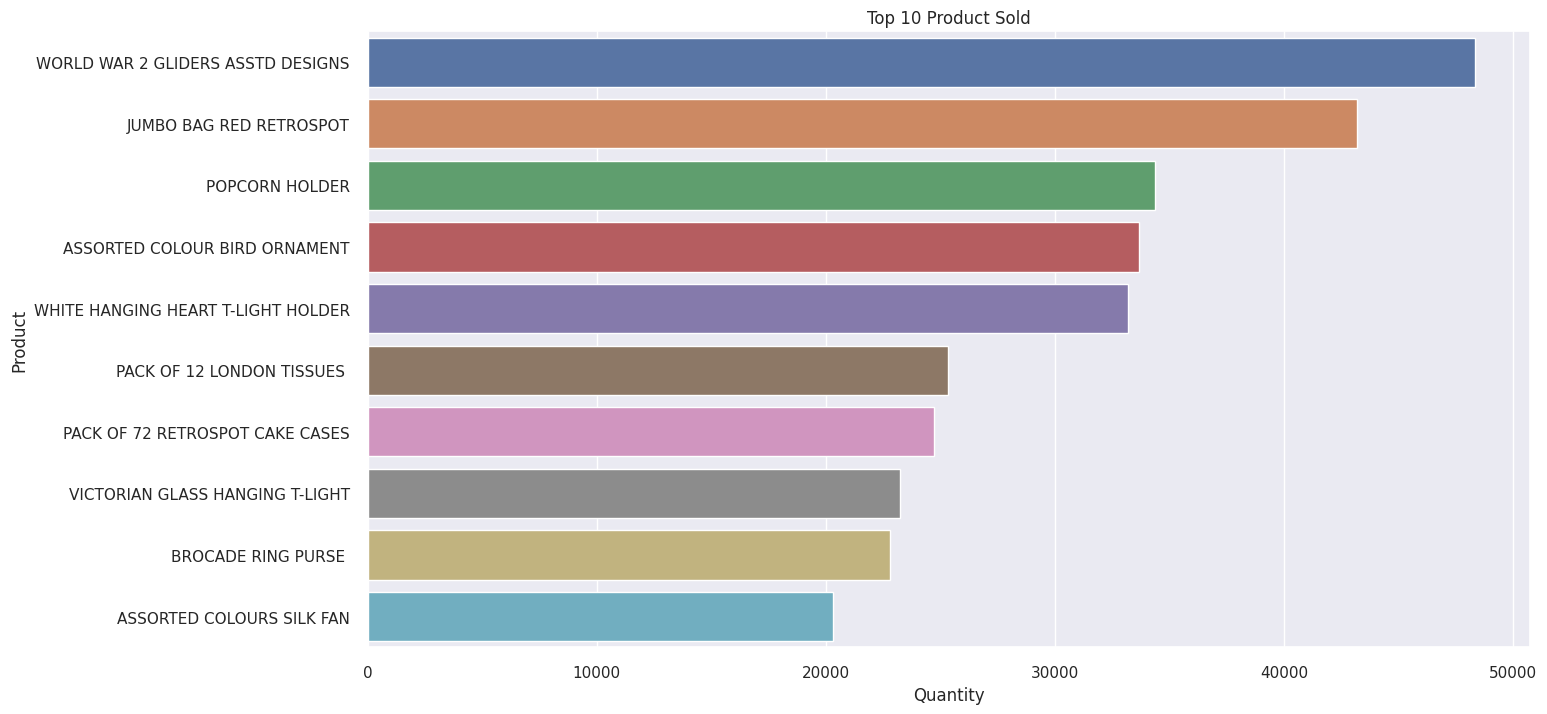

In [66]:
fig = plt.figure(figsize = (15, 8))

sns.barplot(
    data = top_10_product_sold, 
    y = top_10_product_sold.index, x = 'Quantity'
)
plt.title('Top 10 Product Sold')
plt.ylabel('Product')

plt.show()

#2. RFM

In [68]:
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [70]:
recent = dt.datetime(2011, 12, 10, 12, 50, 00)
recent

datetime.datetime(2011, 12, 10, 12, 50)

In [ ]:
rfm_df = pd.DataFrame(data.groupby('CustomerID').agg
    (
        {
            'InvoiceDate': lambda x: (recent - x.max()).days,
            'InvoiceNo': 'count',
            'Revenue': 'sum'
        }
    )
)

In [73]:
rfm_df.rename(
    columns = {
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'Revenue': 'Monetary'
    },
    inplace = True
)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


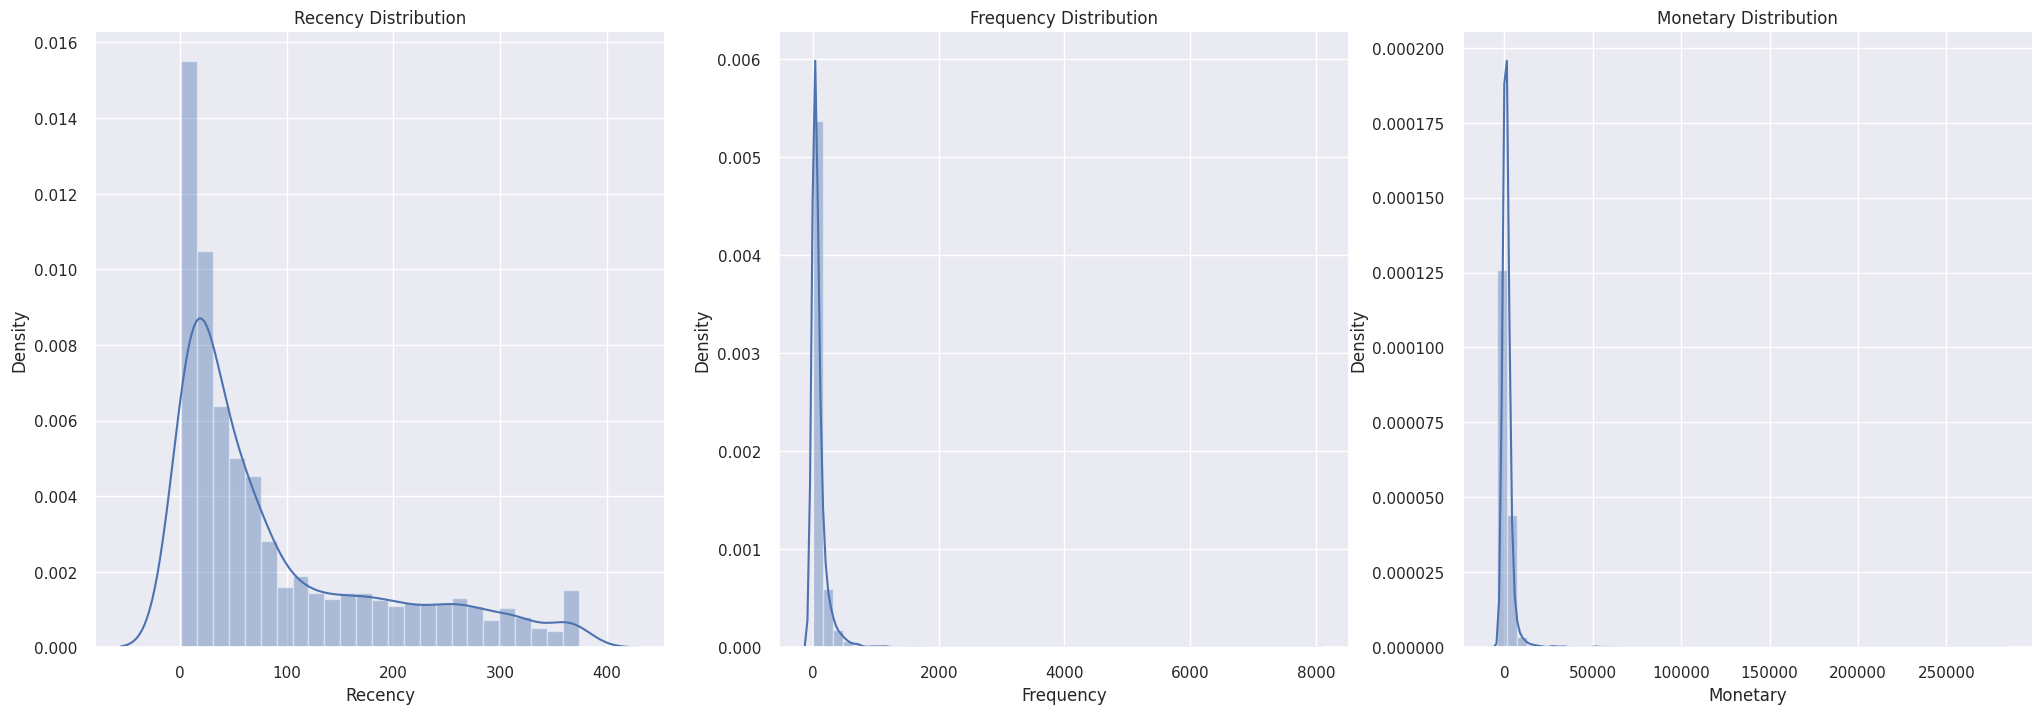

In [86]:
fig, axes = plt.subplots(1, 3, figsize = (25, 8))

sns.distplot(rfm_df['Recency'], ax = axes[0])
axes[0].set_title('Recency Distribution')

sns.distplot(rfm_df['Frequency'], ax = axes[1])
axes[1].set_title('Frequency Distribution')

sns.distplot(rfm_df['Monetary'], ax = axes[2])
axes[2].set_title('Monetary Distribution')

plt.show()

In [88]:
from scipy import stats

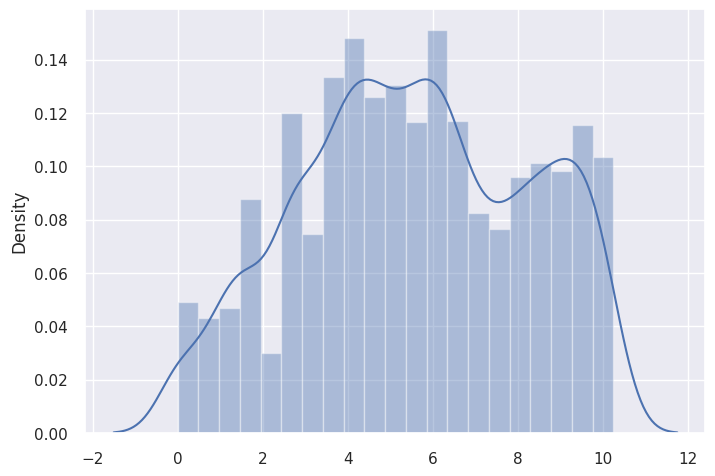

-0.07


In [99]:
test = stats.boxcox(rfm_df['Recency'])[0]
sns.distplot(test)
plt.show()
print(pd.Series(stats.boxcox(rfm_df['Recency'])[0]).skew().round(2))

In [116]:
def skew_analyse(metric):
    fig, ax = plt.subplots(2, 2, figsize = (15, 8))

    sns.distplot(rfm_df[metric], ax = ax[0, 0])
    sns.distplot(np.log(rfm_df[metric]), ax = ax[0, 1])
    sns.distplot(np.sqrt(rfm_df[metric]), ax = ax[1, 0])
    sns.distplot(stats.boxcox(rfm_df[metric])[0], ax = ax[1, 1])

    plt.show()

    print(rfm_df[metric].skew().round(2))
    print(np.log(rfm_df[metric]).skew().round(2))
    print(np.sqrt(rfm_df[metric]).skew().round(2))
    print(pd.Series(stats.boxcox(rfm_df[metric])[0]).skew().round(2))

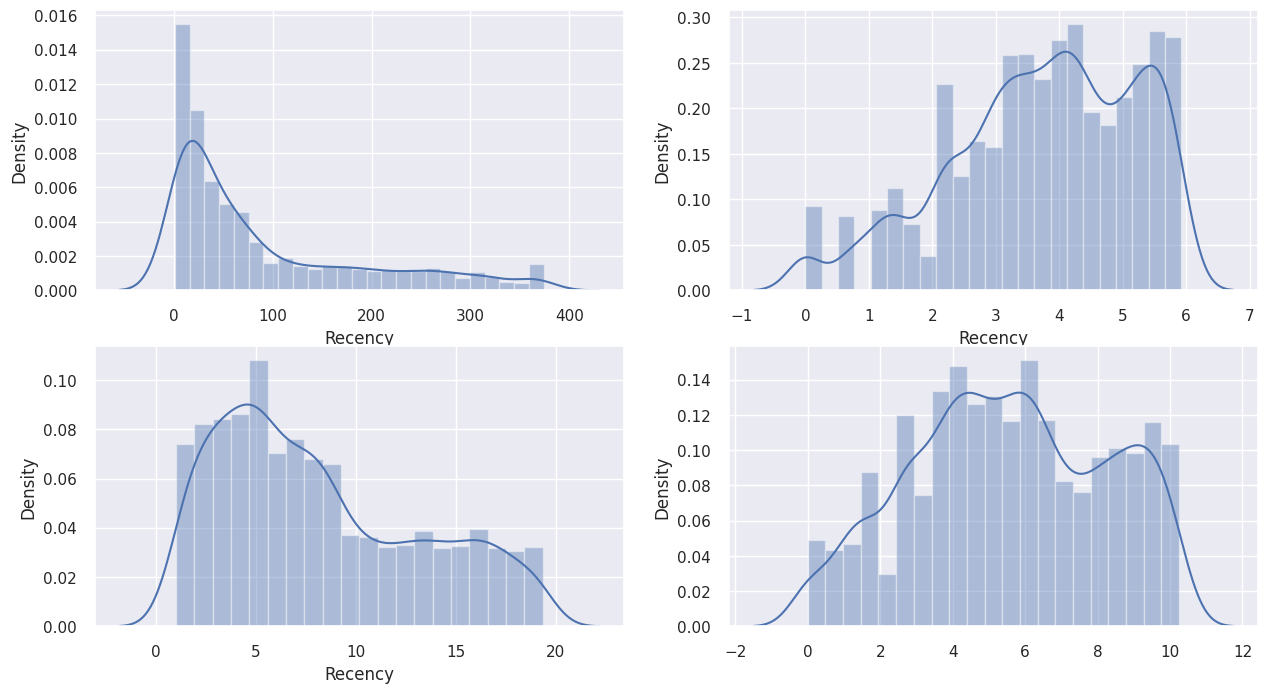

1.25
-0.53
0.59
-0.07


In [117]:
skew_analyse('Recency')

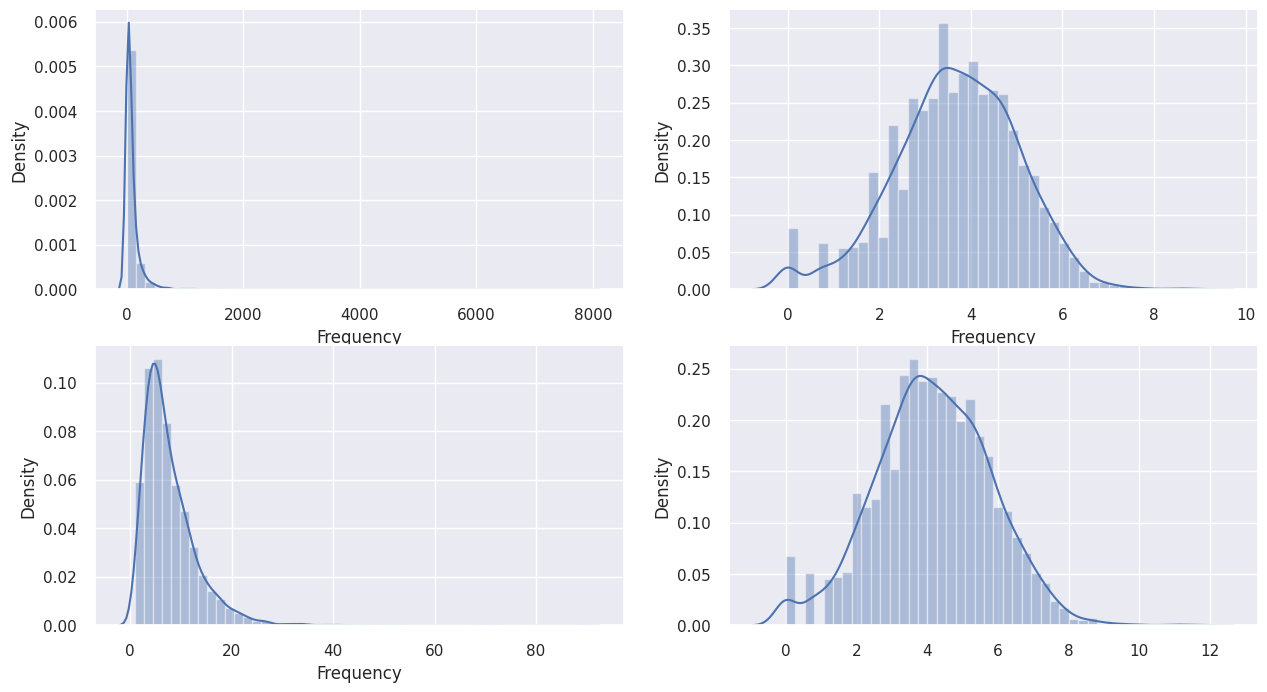

18.15
-0.24
3.2
0.0


In [118]:
skew_analyse('Frequency')

In [121]:
rfm_trans_df = pd.DataFrame()
rfm_trans_df['Recency'] = stats.boxcox(rfm_df['Recency'])[0]
rfm_trans_df['Frequency'] = stats.boxcox(rfm_df['Frequency'])[0]
rfm_trans_df['Monetary'] = pd.Series(np.cbrt(rfm_df['Monetary'])).values
rfm_trans_df.head()

,Recency,Frequency,Monetary
0,9.876619,0.707055,0.000000
1,0.735846,6.060363,16.273929
2,6.384920,3.794006,12.158183
3,3.826255,4.862047,12.068017
4,9.741979,3.075409,6.941001


In [122]:
scaler = preprocessing.StandardScaler()

In [123]:
scaler.fit(rfm_trans_df)
rfm_scaled = scaler.transform(rfm_trans_df)

In [124]:
rfm_scaled[:10]

array([[ 1.61117306, -2.09807168, -1.92564704],
       [-1.79759219,  1.15134635,  1.33054192],
       [ 0.30905346, -0.22431569,  0.50703791],
       [-0.64512083,  0.42397766,  0.48899675],
       [ 1.56096353, -0.66049826, -0.53684845],
       [-0.22873497,  0.62983068,  0.38765185],
       [ 1.15977123, -1.65155744, -1.03231308],
       [ 1.2800456 ,  0.24674289,  0.12682845],
       [ 1.20421462, -0.85048403, -0.38176479],
       [-0.52536769,  0.25983472,  0.89831985]])

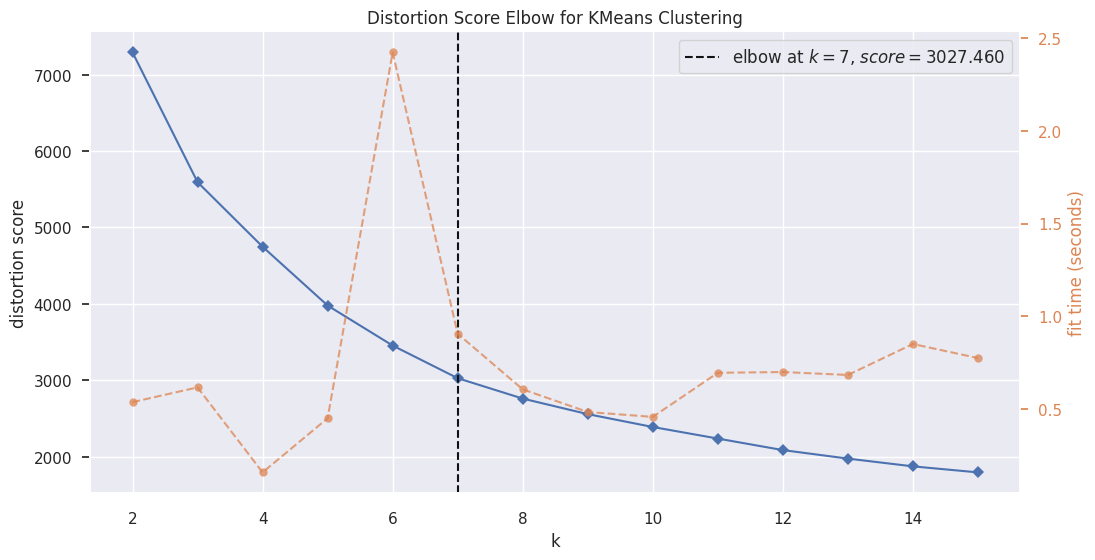

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [125]:
km = KMeans(random_state = 0)
elbow_viz = KElbowVisualizer(km, k = 15, size = (1200, 600))

elbow_viz.fit(rfm_scaled)
elbow_viz.show()

In [ ]:
kmeans_model = KMeans(n_clusters = 7, random_state = 0)
kmeans_model.fit(rfm_scaled)

In [129]:
rfm_df['Cluster'] = kmeans_model.labels_
rfm_df.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,2,0.00,3
12347.0,2,182,4310.00,5
12348.0,75,31,1797.24,6
12349.0,19,73,1757.55,2
12350.0,310,17,334.40,0


In [130]:
rfm_df.groupby('Cluster').agg(
    {
        'Recency': 'mean',
        'Frequency': 'mean',
        'Monetary': 'mean'
    }
).round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,210.81,31.83,497.84
1,40.46,20.36,405.71
2,11.01,84.08,1185.55
3,225.91,5.89,162.37
4,6.35,1161.95,60140.10
5,12.85,316.61,5385.21
6,69.42,105.18,1671.05


In [131]:
rfm_scaled

array([[ 1.61117306, -2.09807168, -1.92564704],
       [-1.79759219,  1.15134635,  1.33054192],
       [ 0.30905346, -0.22431569,  0.50703791],
       ...,
       [-1.14097185, -0.85048403, -0.80307538],
       [-1.48869338,  2.36366091,  0.63453134],
       [-0.10466245,  0.391469  ,  0.52497099]])

In [133]:
labels = kmeans_model.labels_
centroid = kmeans_model.cluster_centers_

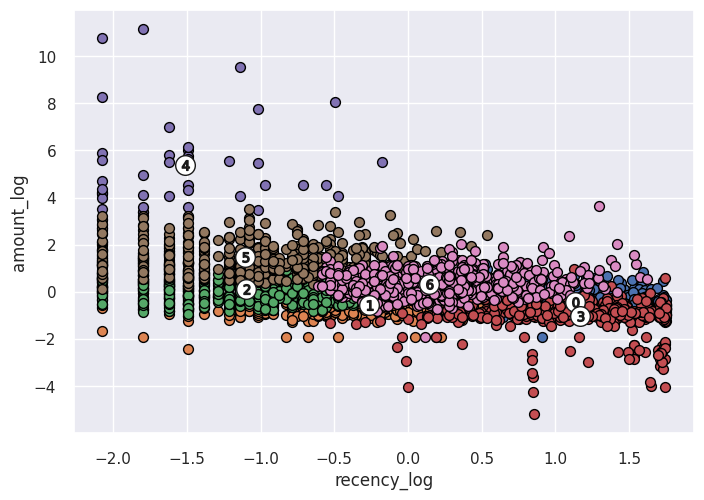

In [136]:
for label in range(7):
    plt.scatter(rfm_scaled[labels == label, 0], rfm_scaled[labels == label, 2], s = 50, edgecolors = 'black')
plt.scatter(centroid[:, 0], centroid[:, 2], marker = 'o', c = "white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centroid):
    plt.scatter(c[0], c[2], marker = '$%d$' % i, alpha = 1, s = 50, edgecolor='k')
plt.xlabel('recency_log')
plt.ylabel('amount_log')
plt.show()

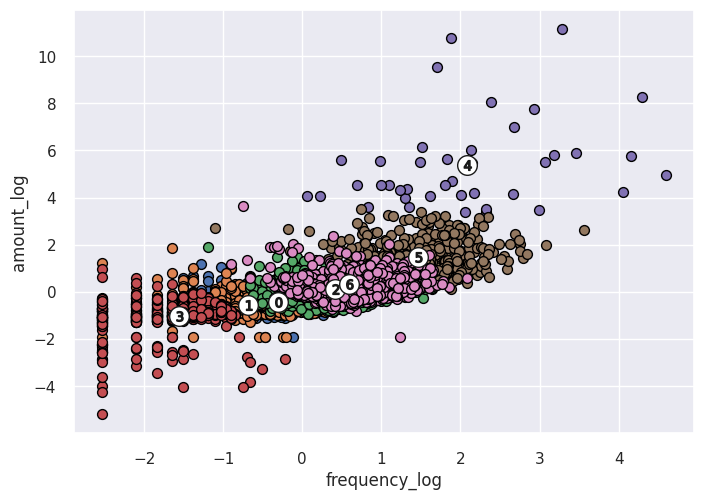

In [137]:
for label in range(7):
    plt.scatter(rfm_scaled[labels == label, 1], rfm_scaled[labels == label, 2], s = 50, edgecolors = 'black')
plt.scatter(centroid[:, 1], centroid[:, 2], marker = 'o', c = "white", alpha = 1, s = 200, edgecolor='k')
for i, c in enumerate(centroid):
    plt.scatter(c[1], c[2], marker = '$%d$' % i, alpha = 1, s = 50, edgecolor='k')
plt.xlabel('frequency_log')
plt.ylabel('amount_log')
plt.show()